Code to replicate the results reported for study 2.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.stats.api as sms
from pyspan.AFC.analysis import *
from pyspan.utils import *
from pyspan.valence import *

/Users/sabinasloman/Box/LoP/pyspan/pyspan/config.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  

# Demographics

In [2]:
# ddf contains data from Democrats
ddf = minidf.loc[minidf.party == "Democrat"]
# rdf contains data from Republicans
rdf = minidf.loc[minidf.party == "Republican"]

In [3]:
len(ddf), len(rdf)

(50, 19)

In [4]:
np.mean(ddf.age), stats.sem(ddf.age)

(40.66, 1.6229501985393067)

In [5]:
ddf.gender.value_counts()

1    30
0    20
Name: gender, dtype: int64

In [6]:
np.mean(rdf.age), stats.sem(rdf.age)

(43.8421052631579, 2.8789040697215458)

In [7]:
rdf.gender.value_counts()

1    10
0     9
Name: gender, dtype: int64

## Descriptive stats

In [8]:
antonyms = {
    "POSITIVE": [ "superior", "joy", "plentiful", "qualified", "laugh",
                  "clever", "rapid", "famous", "useful", "loyal" ],
    "NEGATIVE": [ "inferior", "sorrow", "scarce", "unqualified", "cry",
                  "stupid", "slow", "unknown", "useless", "disloyal" ]
}

In [9]:
def get_valence_bias(i):
    party = minidf.loc[i]["party"].lower()
    condition = minidf.loc[i]["Condition"].lower()
    if party not in ("democrat", "republican"):
        return (np.nan, np.nan, np.nan)
    party = 1 if party == "republican" else 0
    condition = 1 if condition == "republican" else 0
    k = "POSITIVE" if party == condition else "NEGATIVE"
    valence_match = map(lambda w: w in antonyms[k], filter(lambda w: isinstance(w, str), 
                                                           minidf.loc[i][map(str, range(89, 99))]))
    
    return (np.mean(valence_match), party, condition)

In [10]:
arr = np.array(map(get_valence_bias, minidf.index))
valence_match = arr[:,0]
parties = arr[:,1]
conditions = arr[:,2]
ixs_not_nan = np.arange(len(valence_match))[~np.isnan(valence_match)]
valence_match = valence_match[ixs_not_nan]
parties = parties[ixs_not_nan]
conditions = conditions[ixs_not_nan]

In [11]:
x_dd = valence_match[(parties == 0) & (conditions == 0)]
x_dr = 1 - valence_match[(parties == 0) & (conditions == 1)]
x_rd = 1 - valence_match[(parties == 1) & (conditions == 0)]
x_rr = valence_match[(parties == 1) & (conditions == 1)]

Each observation in `x_dd` corresponds to a Democratic participant asked to choose the word most likely to have been spoken by a Democrat, and each observation in `x_rr` corresponds to a Republican participant asked to choose the word most likely to have been spoken by a Republican. Observations are the proportion of positive words the participant selected. 

In [12]:
np.mean(np.append(x_dd, x_rr)), stats.sem(np.append(x_dd, x_rr))

(0.8096774193548386, 0.02678261300448299)

Each observation in `x_dr` corresponds to a Democratic participant asked to choose the word most likely to have been spoken by a Republican, and each observation in `x_rd` corresponds to a Republican participant asked to choose the word most likely to have been spoken by a Democrat. Observations are the proportion of positive words the participant selected. 

In [13]:
np.mean(np.append(x_dr, x_rd)), stats.sem(np.append(x_dr, x_rd))

(0.3736842105263158, 0.032811416525782455)

## Hypothesis test

In [14]:
prop_match = np.append(x_dd, x_rr)
prop_doesnt_match = np.append(x_dr, x_rd)

In [15]:
dsw_pm = sms.DescrStatsW(prop_match)
dsw_pdm = sms.DescrStatsW(prop_doesnt_match)
cm = sms.CompareMeans(dsw_pm, dsw_pdm)
cm.ttest_ind(usevar="unequal", alternative = "larger")

(10.293923175156955, 1.0890127910206365e-15, 66.38400483833256)

Compute difference in means and a confidence region of +- 2 standard errors.

In [16]:
delta = dsw_pm.mean - dsw_pdm.mean
se_delta = cm.std_meandiff_separatevar
print(delta, delta - 2*se_delta, delta + 2*se_delta)

(0.4359932088285227, 0.3512843565455106, 0.5207020611115348)


## Figure 1b

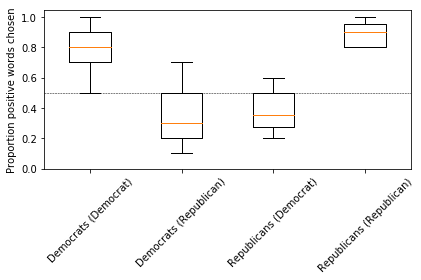

In [17]:
fig, ax = plt.subplots(1)
ax.boxplot([ x_dd, x_dr, x_rd, x_rr ], whis = [5,95], sym = "")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(*xlim)
ax.set_ylim((0,ylim[1]))
ax.plot(xlim, [.5,.5], color = "k", linestyle = "--", linewidth = .5)
ax.set_ylabel("Proportion positive words chosen")
ax.set_xticklabels([ "Democrats (Democrat)", "Democrats (Republican)",
                     "Republicans (Democrat)", 
                     "Republicans (Republican)" ], rotation = 45)
plt.tight_layout()